In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import sys, os
import datetime
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/data/20180913_mictest/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

# Acoustic tomography functions
import ATom.atom_functions as atom

# Microphone comparison
testing new B&K microphones against the old 'button' type.

In [2]:
oldfileindex = pd.read_csv(datapath+'old_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)
newfileindex = pd.read_csv(datapath+'new_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)

### load atom dataset object for meta data

In [3]:
adat = atom.dataset('/Users/nhamilto/Documents/ATom/data/20180913_Data_collection/')

### Load in data from the old mics

In [4]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(oldfileindex)):
    timestamp = oldfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    chardata[str(oldfileindex['OffsetAngle'].iloc[ii])] = testdat['M0'].values
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)
old_mic_data = chardata.copy()

In [5]:
# calculate the number of frames within the file
nframe = int(len(speakerdat) / 10000)
frameindex = [
    speakerdat.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
speakerdat['frame'] = frameseries
speakerdat['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
speakerdat.set_index(['frame', speakerdat.index], inplace=True)

In [6]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

### extract a single speaker chirp

In [7]:
# single frame
speakersamp = speakerdat.xs('frame 0', level=0)
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq # Hz
searchLag = 3 * chirp_record_length * upsamplefactor

# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor, method='linear')
speakerstartindex = np.squeeze(speakersamp.values).nonzero()[0][0] # atom.get_speaker_signal_delay(speakersamp) 

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, chirp_record_length*upsamplefactor, np.array([speakerstartindex]))


### Extract mic signals



In [8]:
# load aux data to get speed of sound
timestamp = oldfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = 2 / c0 # seconds
signalETAs_index = int((signalETAs*samplefreq*upsamplefactor).round())

etaindex = signalETAs_index + speakerstartindex 
# etaindex = etaindex[:].repeat(len(chardata.columns))

In [9]:
rollindex = np.zeros((len(chardata.columns), nframe))
alpha = rollindex.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]

for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)

    micsamp = micsamp.reindex(sortedcols, axis=1)
    start = int(etaindex - chirp_record_length*upsamplefactor)
    end = start+searchLag
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].iloc[start:end]
        covar = np.correlate(np.squeeze(speakersigs.values), temp, mode='same')
        alpha[ic,fi] = int(col) 
        rollindex[ic,fi] = int(searchLag/2 - np.argmax(covar))

# travel time in upsampled index
traveltimeindex = (etaindex - speakerstartindex + rollindex).astype(int)
# travel time in ms
traveltime = traveltimeindex/(samplefreq*upsamplefactor)*1000 

In [10]:
spsig = speakersamp.set_index(speakersamp.index.microsecond/1000)#, inplace=True)
spsig.index.name = 'ms'

mcsig = pd.DataFrame(data=micsamp['0'].values/micsamp['0'].max(), index=micsamp.index.microsecond/1000)
mcsig.index.name = 'ms'

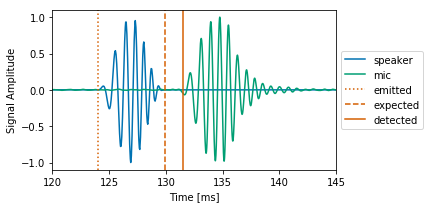

In [11]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(spsig, label='speaker')
ax.plot(mcsig, color='C1', label='mic')

ax.axvline(speakerstartindex/(samplefreq*upsamplefactor)*1000, color='C2', ls=':', label='emitted')
ax.axvline((signalETAs+speakerstartindex/(samplefreq*upsamplefactor))*1000, color='C2', ls='--', label='expected')
ax.axvline(traveltime[11,-1]+speakerstartindex/(samplefreq*upsamplefactor)*1000, color='C2', label='detected')

ax.set_xlim(120,145)
ax.legend(loc=6, bbox_to_anchor=(1,0.5))

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Signal Amplitude')
fig.tight_layout()
# fig.savefig('../figures/signal_times.png', dpi=200, bbox_inches='tight')

Text(0,0.5,'Signal Amplitude')

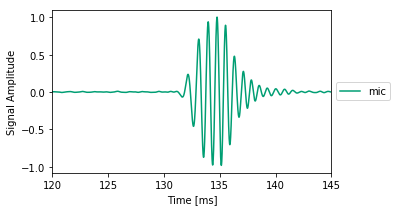

In [12]:
fig,ax = plt.subplots(figsize=(5,3))


ax.plot(mcsig, color='C1', label='mic')

# ax.axvline(speakerstartindex/(samplefreq*upsamplefactor)*1000, color='C2', ls=':', label='emitted')
# ax.axvline((signalETAs+speakerstartindex/(samplefreq*upsamplefactor))*1000, color='C2', ls='--', label='expected')
# ax.axvline(traveltime[11,-1]+speakerstartindex/(samplefreq*upsamplefactor)*1000, color='C2', label='detected')

ax.set_xlim(120,145)
ax.legend(loc=6, bbox_to_anchor=(1,0.5))

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Signal Amplitude')
# fig.tight_layout()
# fig.savefig('../figures/signal_times.png', dpi=200, bbox_inches='tight')

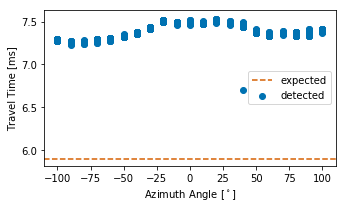

In [13]:
fig,ax = plt.subplots(figsize=(5,3))

ax.scatter(alpha.flatten(), traveltime.flatten(), label='detected')
ax.axhline((etaindex - speakerstartindex)/(samplefreq*upsamplefactor)*1000, label='expected', ls='--', color='C2')

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

# ax.set_ylim(0.1285, 0.1325)
fig.tight_layout()
fig.savefig('../figures/old_mic_travel_time.png', dpi=200, bbox_inches='tight')

In [14]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_oldmicdata.csv')
np.savetxt(savefile, traveltime.T)

# Data from new microphone

In [15]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()
catdat = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(newfileindex)):
    timestamp = newfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    newcol = str(newfileindex['OffsetAngle'].iloc[ii]) + '_' + str(ii%3)
    catdat = pd.concat([catdat, testdat.iloc[0:1200000]], ignore_index=True, axis=0) 
    if ii%3 == 2:
        if ii==2:
            chardata = catdat
        chardata[str(newfileindex['OffsetAngle'].iloc[ii])] = catdat
        del catdat
        catdat = pd.DataFrame()
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.drop('M0', axis=1, inplace=True)
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)
new_mic_data = chardata.copy()

In [16]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

framelength = len(chardata.xs('frame 0', level=0))

In [17]:
# single frame
speakersamp = speakerdat.iloc[0:framelength]
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq
searchLag = 3 * chirp_record_length * upsamplefactor
# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor)
speakerstartindex = np.array([np.squeeze(speakersamp.values.round(5)).nonzero()[0][0]]) 

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, chirp_record_length*upsamplefactor, speakerstartindex)


In [18]:
# load aux data to get speed of sound
timestamp = newfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = 2 / c0 # seconds
signalETAs_index = int((signalETAs*samplefreq*upsamplefactor).round())

etaindex = signalETAs_index + speakerstartindex 
# etaindex = etaindex[:].repeat(len(chardata.columns))

In [19]:
rollindex = np.zeros((len(chardata.columns), nframe))
alpha = rollindex.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]

for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)

    micsamp = micsamp.reindex(sortedcols, axis=1)
    start = int(etaindex - chirp_record_length*upsamplefactor)
    end = start+searchLag
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].iloc[start:end]
        covar = np.correlate(np.squeeze(speakersigs.values), temp, mode='same')
        alpha[ic,fi] = int(col) 
        rollindex[ic,fi] = int(searchLag/2 - np.argmax(covar))

# travel time in upsampled index
traveltimeindex = (etaindex - speakerstartindex + rollindex).astype(int)
# travel time in ms
traveltime = traveltimeindex/(samplefreq*upsamplefactor)*1000 

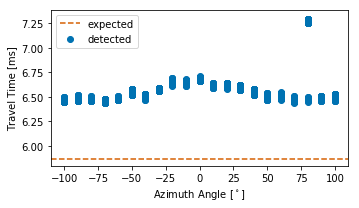

In [20]:
fig,ax = plt.subplots(figsize=(5,3))

ax.scatter(alpha.flatten(), traveltime.flatten(), label='detected')
ax.axhline((etaindex - speakerstartindex)/(samplefreq*upsamplefactor)*1000, label='expected', ls='--', color='C2')

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

# ax.set_ylim(0.1285, 0.1325)
fig.tight_layout()
fig.savefig('../figures/new_mic_travel_time.png', dpi=200, bbox_inches='tight')

In [21]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_newmicdata.csv')
np.savetxt(savefile, traveltime.T)

## Re-load processed data for plotting

In [22]:
# data from new mic
newdat = pd.read_csv(os.path.join(datapath,today+'_newmicdata.csv'), 
                     delim_whitespace=True, names=[str(x) for x in alpha[:,0]])

In [23]:
# data from old mic
olddat = pd.read_csv(os.path.join(datapath,today+'_oldmicdata.csv'), 
                     delim_whitespace=True, names=[str(x) for x in alpha[:,0]])

#### Plot filtered data from new mic

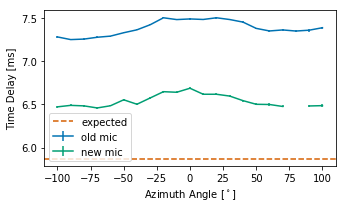

In [24]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
# newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
# oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.array([x*10 for x in range(-10,11)]), oldstats['mean'].values, yerr=oldstats['std'], label='old mic')

ax.errorbar(np.array([x*10 for x in range(-10,11)]), newstats['mean'].values, yerr=newstats['std'], label='new mic')

ax.axhline((etaindex - speakerstartindex)/(samplefreq*upsamplefactor)*1000, label='expected', ls='--', color='C2')

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time Delay [ms]')

ax.legend()

fig.tight_layout()
fig.savefig('../figures/both_mic_travel_time.png', dpi=200, bbox_inches='tight')

In [25]:
from scipy import optimize

def cosine_fit_func(x, a, b, c):
    return a * np.cos(b * x)+c

In [95]:
def rsquared(data, fitdata):
    ss_res = np.sum(np.mean((data-fitdata)**2))
    ss_tot = np.sum(np.mean((data-data.mean())**2))
    rsquared = 1 - ss_res/ss_tot
    return rsquared

### Speaker characterization data
signal latency at several fixed radial distances from the center of the speaker aperature as a function of azimuth angle

In [26]:
colnames = ['azangle'] + [x for x in range(120)]
speaker = pd.read_csv('../../data/speaker_char_raw_data_210818.csv', names=colnames, skiprows=1)

speaker['azangle'].ffill(inplace=True)
speaker = speaker.set_index('azangle').drop('4m', axis=0)
speaker.set_index(pd.to_numeric(speaker.index), inplace=True)
speaker['radius'] = np.concatenate(((2*np.ones(int(len(speaker.index)/2))).astype(int), (4*np.ones(int(len(speaker.index)/2+1))).astype(int)))
speaker.reset_index(inplace=True)
speaker.set_index(['radius','azangle'], inplace=True)


- calculate mean offset time,
- exclude outliers,
- separate by radial distance, 
- subtract minimum value, 

In [66]:
# get mean values over 120 records
meanoff = speaker.T.mean()

# remove and replace obvious outliers
meanoff.loc[2,[-40,40]] = np.nan
meanoff.interpolate(inplace=True)
meanoff.loc[4,[-100]] = np.nan
meanoff.bfill(inplace=True)

# extract data for radial distance = 2 m
rad2 = meanoff.xs(2, level=0) - meanoff.xs(2, level=0).min()
rad2 = rad2.reset_index()
rad2.columns = ['azangle', 'offset']

# extract data for radial distance = 4 m
rad4 = meanoff.xs(4, level=0) - meanoff.xs(4, level=0).min()
rad4 = rad4.reset_index()
rad4.columns = ['azangle', 'offset']

# fit cosine curve to data
rad2params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad2['azangle']), rad2['offset'], p0=[0.15, 2, 0.15])
rad4params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad4['azangle']), rad4['offset'], p0=[0.15, 2, 0.15])

rad2fit = cosine_fit_func(np.radians(rad2['azangle']), rad2params[0], rad2params[1], rad2params[2])
rad4fit = cosine_fit_func(np.radians(rad4['azangle']), rad4params[0], rad4params[1], rad4params[2])

In [101]:
rad2err = rsquared(rad2['offset'], rad2fit)
print(rad2params, rad2err.round(3))

[0.10365713 2.35956975 0.14671606] 0.892


In [100]:
rad4err = rsquared(rad4['offset'], rad4fit)
print(rad4params, rad4err.round(3))

[0.1023492  2.46967444 0.14699462] 0.828


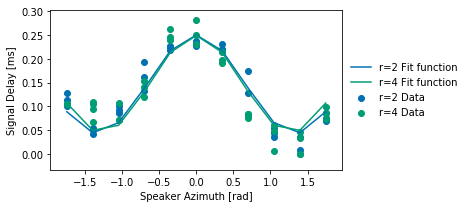

In [68]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.radians(rad2['azangle']), rad2['offset'], label='r=2 Data')
ax.plot(np.radians(rad2['azangle']), rad2fit,
         label='r=2 Fit function')

ax.scatter(np.radians(rad4['azangle']), rad4['offset'], label='r=4 Data', color='C1')
ax.plot(np.radians(rad4['azangle']), rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Speaker Azimuth [rad]')
ax.set_ylabel('Signal Delay [ms]')

fig.tight_layout()
# fig.savefig('../figures/speaker_char_time_offsets.png', dpi=200, bbox_inches='tight')

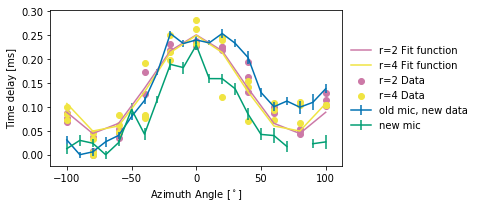

In [29]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
            oldstats['mean'].values, 
            yerr=oldstats['std'],
           label='old mic, new data')

ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
            newstats['mean'], 
            yerr=newstats['std'],
            label='new mic', color='C1')

ax.scatter(rad2['azangle'][-1::-1], rad2['offset'], label='r=2 Data', color='C3')
ax.plot(rad2['azangle'], rad2fit, label='r=2 Fit function', color='C3')

ax.scatter(rad4['azangle'][-1::-1], rad4['offset'], label='r=4 Data', color='C4')
ax.plot(rad4['azangle'], rad4fit, label='r=4 Fit function', color='C4')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

fig.tight_layout()
fig.savefig('../figures/all_mic_test.png', dpi=200, bbox_inches='tight')

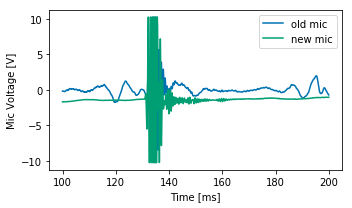

In [30]:
otmp = old_mic_data.set_index(old_mic_data.index.microseconds/1000)
ntmp = new_mic_data.set_index(new_mic_data.index.microseconds/1000)

fig,ax = plt.subplots(figsize=(5,3))

otmp['0'].iloc[2000:4000].plot(ax=ax, label='old mic')
ntmp['0'].iloc[2000:4000].plot(ax=ax, label='new mic')

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Mic Voltage [V]')
ax.legend()

fig.tight_layout()
fig.savefig('../figures/mic_timeseries.png', dpi=200, bbox_inches='tight')

In [61]:
new_mic_data.shape

(3600000, 21)

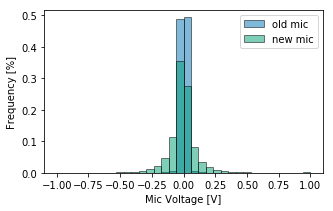

In [103]:
fig,ax = plt.subplots(figsize=(5,3))

nbins = 35

pdat = old_mic_data.values.flatten()
ax.hist(pdat/pdat.max(), bins = np.linspace(-1,1,nbins), 
        weights=np.ones(len(pdat))/len(pdat), 
        edgecolor='k', alpha=0.5)

pdat = new_mic_data.values.flatten()
ax.hist(pdat/pdat.max(), bins = np.linspace(-1,1,nbins), 
        weights=np.ones(len(pdat))/len(pdat), 
        edgecolor='k', alpha=0.5)



ax.set_xlabel('Mic Voltage [V]')
ax.set_ylabel('Frequency [%]')

ax.legend(['old mic','new mic'])
fig.savefig('../figures/mic_hist.png', dpi=200, bbox_inches='tight')

In [32]:
new0 = np.abs(np.fft.fft(new_mic_data['0'].values))**2
newfreqs = np.fft.fftfreq(len(new_mic_data['0'].values), d=1/20000)

old0 = np.abs(np.fft.fft(old_mic_data['0'].values))**2
oldfreqs = np.fft.fftfreq(len(old_mic_data['0'].values), d=1/20000)


In [33]:
adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2

0.85

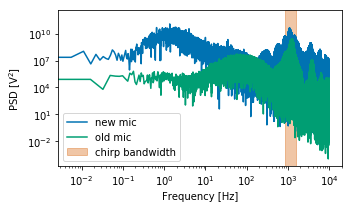

In [34]:
fig=plt.figure(figsize=(5,3))

plt.plot(newfreqs[0:int(len(new0)/2)], new0[0:int(len(new0)/2)], label='new mic')
plt.plot(oldfreqs[0:int(len(old0)/2)], old0[0:int(len(old0)/2)], label='old mic')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V$^2$]')

band = plt.axvspan(1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2), 
            1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2), 
                  color='C2', alpha=0.35, label='chirp bandwidth')

plt.legend()

fig.tight_layout()
fig.savefig('../figures/mic_psd.png', dpi=200, bbox_inches='tight')

In [35]:
otmp = old_mic_data.copy()
# calculate the number of frames within the file
nframe = int(len(otmp) / 10000)
frameindex = [
    otmp.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
otmp['frame'] = frameseries
otmp['frame'].ffill(inplace=True)

a = otmp.index[0:10000].microseconds/1000
arep = np.array([a.tolist()]*nframe).flatten()
otmp = otmp.set_index(['frame', arep])
otmp.index.names = ['frame', 'ms']

In [36]:
ntmp = new_mic_data.copy()
# calculate the number of frames within the file
nframe = int(len(ntmp) / 10000)
frameindex = [
    ntmp.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
ntmp['frame'] = frameseries
ntmp['frame'].ffill(inplace=True)

a = ntmp.index[0:10000].microseconds/1000
arep = np.array([a.tolist()]*nframe).flatten()
ntmp = ntmp.set_index(['frame', arep])
ntmp.index.names = ['frame', 'ms']

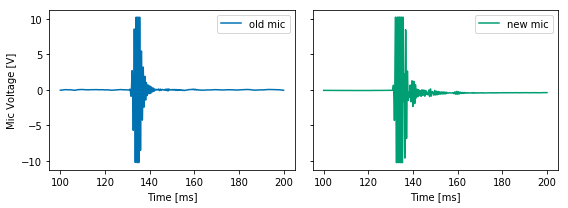

In [37]:
fig,ax = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
otmp.groupby('ms').mean()['0'].loc[100:200].plot(ax=ax[0], label='old mic')
ntmp.groupby('ms').mean()['0'].loc[100:200].plot(ax=ax[1], label='new mic', color='C1')

ax[0].set_ylabel('Mic Voltage [V]')
ax[0].set_xlabel('Time [ms]')
ax[1].set_xlabel('Time [ms]')
ax[0].legend()
ax[1].legend()

fig.tight_layout()
fig.savefig('../figures/mic_average_chirp.png', dpi=200, bbox_inches='tight')

In [112]:
ospec = otmp.groupby('frame').apply(np.fft.fft, axis=0).mean()
ofreqs = np.fft.fftfreq(len(ospec), d=1/20000.0)
ofreqs = ofreqs[0:5000]
ospec = np.abs(ospec[0:5000,:])**2

nspec = ntmp.groupby('frame').apply(np.fft.fft, axis=0).mean()
nfreqs = np.fft.fftfreq(len(nspec), d=1/20000.0)
nfreqs = nfreqs[0:5000]
nspec = np.abs(nspec[0:5000,:])**2

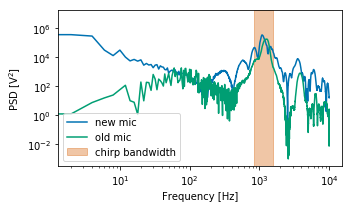

In [113]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(nfreqs, nspec[:,0], label='new mic')
ax.plot(ofreqs, ospec[:,0], label='old mic')

band = ax.axvspan(1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2), 
            1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2), 
                  color='C2', alpha=0.35, label='chirp bandwidth')

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V$^2$]')

fig.tight_layout()
fig.savefig('../figures/average_psd.png', dpi=200, bbox_inches='tight')

In [41]:
oftmp = atom.freq_filter(otmp.xs('frame 0', level=0), adat.meta.filter_freq_inds)
nftmp = atom.freq_filter(ntmp.xs('frame 0', level=0), adat.meta.filter_freq_inds)

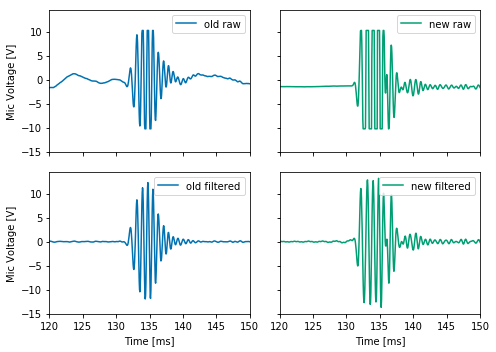

In [109]:
fig,ax = plt.subplots(2,2, figsize=(7,5), sharex=True, sharey=True)
ax=ax.flatten()
otmp.xs('frame 0', level=0)['0'].plot(ax=ax[0], label='old raw')
ntmp.xs('frame 0', level=0)['0'].plot(ax=ax[1], label='new raw', color='C1')

oftmp['0'].plot(ax=ax[2], label='old filtered', color='C0')
nftmp['0'].plot(ax=ax[3], label='new filtered', color='C1')

for axi in range(len(ax)):
    ax[axi].set_xlim(120,150)
    ax[axi].set_xlabel('Time [ms]')
    ax[axi].set_ylabel('Mic Voltage [V]')
    ax[axi].legend()

fig.tight_layout()
fig.savefig('../figures/mic_filtered_chirp.png', dpi=200, bbox_inches='tight')

In [43]:
otmp_filt = otmp.groupby('frame').apply(atom.freq_filter, adat.meta.filter_freq_inds)
ntmp_filt = ntmp.groupby('frame').apply(atom.freq_filter, adat.meta.filter_freq_inds)

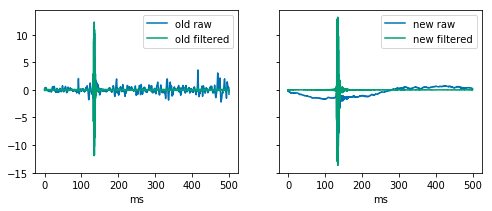

In [110]:
fig,ax = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)

otmp.xs('frame 0', level=0)['0'].plot(ax=ax[0], label='old raw')
otmp_filt.xs('frame 0', level=0)['0'].plot(ax=ax[0], label='old filtered')

ntmp.xs('frame 0', level=0)['0'].plot(ax=ax[1], label='new raw')
ntmp_filt.xs('frame 0', level=0)['0'].plot(ax=ax[1], label='new filtered')

ax[0].legend()
ax[1].legend()

# ax[0].set_xlim(0,250)
# ax[0].set_xlim(0,250)
fig.savefig('../figures/mic_timeseries.png', dpi=200, bbox_inches='tight')

In [45]:
ospec = otmp_filt.groupby('frame').apply(np.fft.fft, axis=0).mean()
ofreqs = np.fft.fftfreq(len(ospec), d=1/20000.0)
ofreqs = ofreqs[0:5000]
ospec = np.abs(ospec[0:5000,:])**2

nspec = ntmp_filt.groupby('frame').apply(np.fft.fft, axis=0).mean()
nfreqs = np.fft.fftfreq(len(nspec), d=1/20000.0)
nfreqs = nfreqs[0:5000]
nspec = np.abs(nspec[0:5000,:])**2

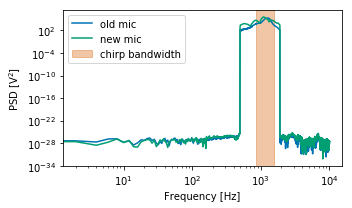

In [46]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(ofreqs, ospec[:,0], label='old mic')
ax.plot(nfreqs, nspec[:,0], label='new mic')

band = ax.axvspan(1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2), 
            1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2), 
                  color='C2', alpha=0.35, label='chirp bandwidth')

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V$^2$]')

fig.tight_layout()
fig.savefig('../figures/average_psd_filtered.png', dpi=200, bbox_inches='tight')

In [47]:
tsig = otmp.xs('frame 0', level=0)['0']

lowcut = 1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2)
hicut = 1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2)

fsig = atom.butter_bandpass_filter(tsig, lowcut, hicut, 20000)
fsig = pd.Series(data=fsig, index=tsig.index)

dsig = otmp_filt.xs('frame 0', level=0)['0']

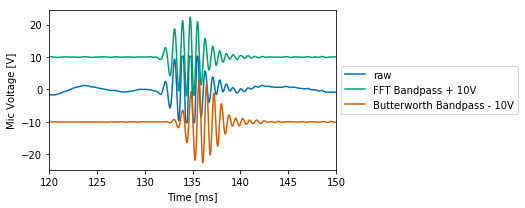

In [48]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(tsig, label='raw')
ax.plot(dsig+10, label='FFT Bandpass + 10V')
ax.plot(fsig-10, label='Butterworth Bandpass - 10V')


ax.set_xlim(120,150)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Mic Voltage [V]')
ax.legend(loc=6, bbox_to_anchor=(1,0.5))

fig.tight_layout()
fig.savefig('../figures/filtered_chip_comp.png', dpi=200, bbox_inches='tight')


In [133]:
tspec = np.abs(np.fft.fft(tsig))**2
fspec = np.abs(np.fft.fft(fsig))**2
dspec = np.abs(np.fft.fft(dsig))**2

ofreqs = np.fft.fftfreq(len(dspec), d=1/20000.0)
ofreqs = ofreqs[0:5000]

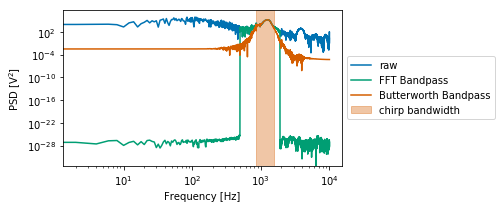

In [135]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(ofreqs, tspec[0:5000], label='raw')
ax.plot(ofreqs, dspec[0:5000], label='FFT Bandpass')
ax.plot(ofreqs, fspec[0:5000], label='Butterworth Bandpass')


band = ax.axvspan(1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2), 
            1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2), 
                  color='C2', alpha=0.35, label='chirp bandwidth')

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc=6, bbox_to_anchor=(1,0.5))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V$^2$]')

fig.tight_layout()

fig.savefig('../figures/filter_comparison.png', dpi=200, bbox_inches='tight')


In [136]:
traveltime.shape

(21, 360)

In [161]:
angles = [r'$\theta =$' + str(x*10) + '$^\circ$' for x in range(-10, 11)]

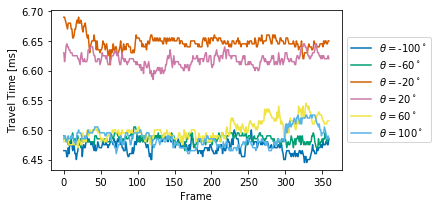

In [162]:
fig, ax = plt.subplots(figsize=(5,3))

ax.plot(traveltime[::4,:].T)
ax.legend([x for x in angles[::4]], loc=6, bbox_to_anchor=(1,0.5))
ax.set_xlabel('Frame')
ax.set_ylabel('Travel Time [ms]')
fig.tight_layout()
fig.savefig('../figures/travel_times.png', dpi=200, bbox_inches='tight')
